# Coronavirus COVID-19 project
Objective: Find interesting positions based on the multiple alignment files

In [2]:
# Read fasta file

def read_fasta(fasta_file):

    fasta_dict = dict()
    with open (fasta_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            if '>' in line:
                key = line[1:-1]
                fasta_dict[key] = ''
            else:
                fasta_dict[key] += line[:-1].upper()
    return fasta_dict

# Read aligned fasta file
aligned_fasta = '../dataset/regional_sequences/multiple_regional_sequences_aligned_filtered.fasta'
aligned_dict = read_fasta(aligned_fasta)

# Read unaligned fasta
unaligned_fasta = '../dataset/regional_sequences/multiple_regional_sequences_unaligned_filtered.fasta'
unaligned_dict = read_fasta(unaligned_fasta)

In [3]:
# Get accession names and prepare numpy array
import numpy as np

accession_array = []
aligned_seq_array = []
for name, sequence in aligned_dict.items():
    aligned_seq_array.append(list(sequence))
    accession_array.append(name.split('|')[0][:-1])
    
aligned_seq_array = np.array(aligned_seq_array)
accession_array = np.array(accession_array)

In [4]:
# Replace non A,T,G,C with -
aligned_seq_array = np.where(np.isin(aligned_seq_array, ['A', 'T', 'G', 'C']), aligned_seq_array, '-')

In [5]:
aligned_ref = np.array(list(aligned_dict['NC_045512 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1| complete genome']))
unaligned_ref = np.array(list(unaligned_dict['NC_045512 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1| complete genome']))

In [6]:
# Get the dictionary of key ref. aligned position sequance, value reference actual position
aligned_pos_translator = dict() # Translate aligned position to unaligned position
ptr_1 = 0
ptr_2 = 0

while ptr_2 < len(unaligned_ref):

#     print(aligned_ref[ptr_1], unaligned_ref[ptr_2])
    if aligned_ref[ptr_1] == unaligned_ref[ptr_2]:
        
        aligned_pos_translator[ptr_1] = ptr_2
        ptr_1 += 1
        ptr_2 += 1
    
    else:
        ptr_1 += 1

unaligned_pos_translator = dict() # Make the opposite dictionary
for key, value in list(aligned_pos_translator.items()):
    unaligned_pos_translator[value] = key

In [7]:
# Count the bases on each position, then calculate the non NA ratios
# For each position, count how many As, Ts, Gs, Cs, and -s, represent them in a 5-dimensional vector with counts of A,T,G,C and - respectively.
def count_bases(position_vector):
    count_vector = np.zeros(5)
    bases = ['A', 'T', 'G', 'C', '-']
    
    for i in range(len(bases)):
        base = bases[i]
        
        # Filter
        base_filter = position_vector == base
        count_vector[i] += len(position_vector[base_filter])
    
    return count_vector


base_counts = []
for pos in range(aligned_seq_array.shape[1]):
    position_vec = aligned_seq_array[:, pos]
    
    base_counts.append(count_bases(position_vec))
base_counts = np.array(base_counts).transpose()

In [8]:
# Get the base proportions for all non-NA entries

base_proportions = []
for pos in range(base_counts.shape[1]):
    position_vec = base_counts[:4, pos]
    sum_current_vec = np.sum(position_vec)
    base_proportions.append(position_vec/sum_current_vec)

base_proportions = np.array(base_proportions).transpose()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [9]:
# Get variance for each spot
var_aligned = np.var(base_proportions, axis = 0)

unalign_mask = np.isin(np.array([i for i in range(len(aligned_ref))]), list(aligned_pos_translator.keys())) # Mask aligned
var_unaligned = var_aligned[unalign_mask] # Position according to the original reference length

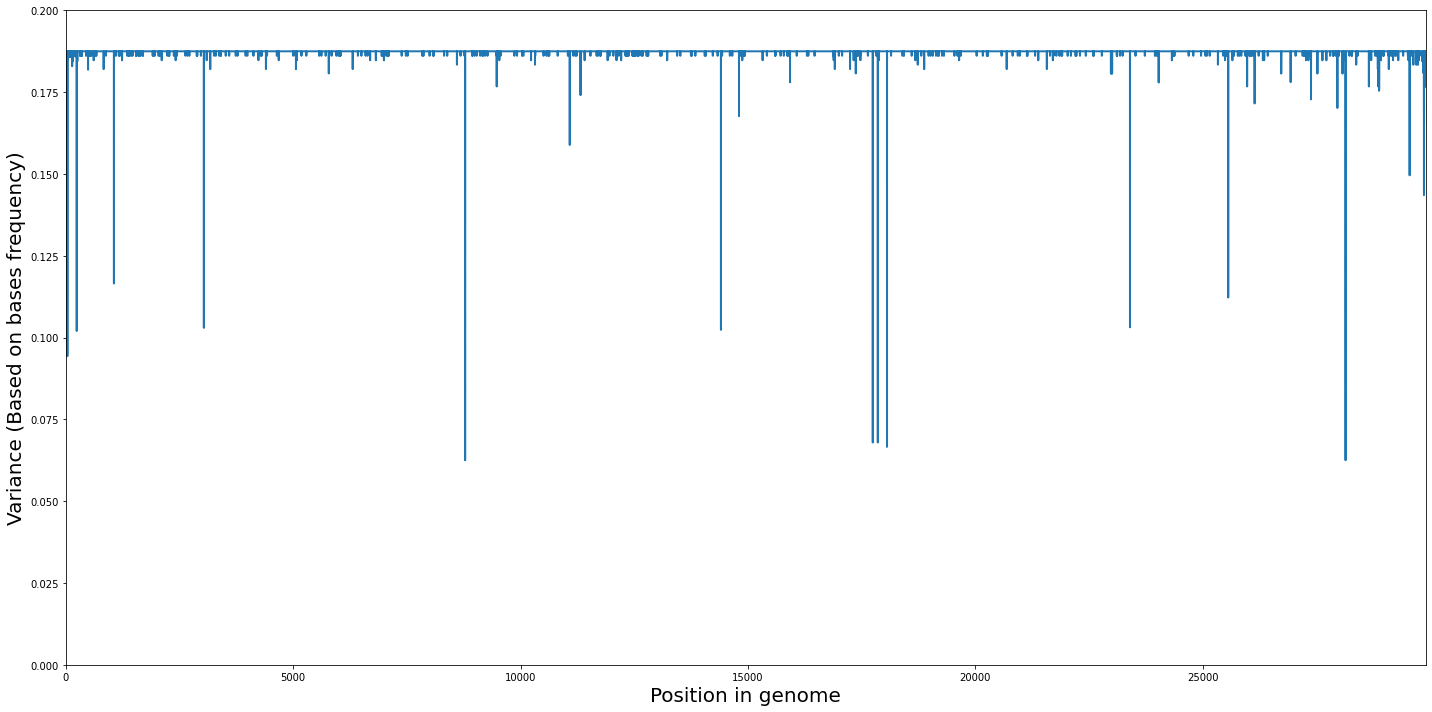

In [10]:
# Visualize variation in every spot

import matplotlib.pyplot as plt

def visualize_var(var_array, start, end):
    
    # Setup figure
    fig = plt.figure(figsize=(20, 10))
    plt.xlabel('Position in genome', size=20)
    plt.ylabel('Variance (Based on bases frequency)', size=20)
    plt.xlim((start, end))
    plt.ylim((0, 0.2))
    
    # Prep data
    x_values = np.arange(len(var_array))
    y_values = var_array
    
    # Plot data
    plt.plot(x_values, y_values, linewidth=2)
    plt.tight_layout()
#     plt.savefig('../presentation/figures/variance_accross_genome.png')
    plt.show()
    
    
visualize_var(var_unaligned, 0, len(var_unaligned))

## Downstream analysis on positions of interest
Genes that code for protein for:
- ACE2
- RBD
- NSP2
- pp1a
- DPP4

In [11]:
# ALWAYS USE UNALIGNED!
def generate_variance_mask(ths, var_unaligned=var_unaligned): # Generate for unaligned position that has interesting positions
    mask = var_unaligned < ths
    return mask

def generate_roi_mask(start, end, unaligned_ref=unaligned_ref):
    # The start and end positions are indexed 1, so we adjust!
    adj_start = start - 1
    adj_end = end - 1
    
    # Position mask
    position_mask = np.repeat(False, len(unaligned_ref))
    position_mask[adj_start:adj_end + 1] = True
    
    return position_mask

In [12]:
# Get regions of interest (roi)
import pandas as pd
bed_path = '../dataset/interesting_regions.bed'

roi = pd.read_csv(bed_path,skiprows=1)

In [13]:
# Make dosage matrix (0 if same as reference, 1 if alternate)
dosage_matrix = np.zeros(aligned_seq_array[:, :].shape)
dosage_matrix[aligned_seq_array[:, :] != aligned_seq_array[0, :]] = 1

# Translate dosage matrix to reference positions
dosage_matrix = dosage_matrix[:, unalign_mask]

In [14]:
def get_dosage_matrix_interesting_regions(start, end, ths, dosage_matrix=dosage_matrix):
    '''
    Returns dosage matrix for a given region, with specific maximum variance threshold
    
    Args:
        - start: start position of region in reference genome
        - end: end position of region in reference genome
        - ths: maximum variance, # IF NO VARIANCE THS, USE ths = 1
    '''
    
    # Variance threshold mask
    ths_mask = generate_variance_mask(ths)

    
    # Generate region of interest mask
    roi_mask = generate_roi_mask(start, end)

    # Combine mask
    combined_mask = ths_mask & roi_mask
    filtered_dosage = dosage_matrix[:, combined_mask]
    
    
    return filtered_dosage
    
test_dosage = get_dosage_matrix_interesting_regions(1, len(unaligned_ref), 1)

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def conduct_pca_on_dosage_matrix(input_dosage):
    # Conduct PCA
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(input_dosage)
    
    # Get PC1 and PC2 matrix
    return PCs, pca.explained_variance_ratio_

def conduct_pca_on_ohe_tensor(input_tensor):
    # Conduct PCA
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(input_tensor)
    print(pca.explained_variance_)
    # Get PC1 and PC2 matrix
    return PCs, pca.explained_variance_


## Parse meta information

In [16]:
# Get accession list from the dictionary
accession_list = []
for key in list(aligned_dict.keys()):
    accession_list.append(key.split(' |')[0])

In [17]:
# Parse meta info
meta_info = pd.read_csv('../dataset/accession_data.csv')

# Filter only use the meta_info in the dictionary
meta_info = meta_info.loc[meta_info.loc[:, 'Accession'].isin(accession_list), :]

meta_info.loc[pd.isna(meta_info.loc[:, 'Geo_Location']), 'Geo_Location'] = 'NA' # CHange NA Value for simplicity

In [18]:
# Helper function, generate random color (copied)
import random

def rand_web_color_hex():
    rgb = ""
    for _ in "RGB":
        i = random.randrange(0, 2**8)
        rgb += i.to_bytes(1, "big").hex()
    return f'#{rgb}'

In [19]:
# Make color dictionary
col_dict = dict()

for geo_loc in list(set(meta_info.loc[:, 'Geo_Location'].values)):
    col_dict[geo_loc] = rand_web_color_hex()

In [20]:
# Temperature dict
import pandas as pd
temperature_df = pd.read_csv('../dataset/country_temps.csv', names = ['country', 'temp']).set_index('country')
temperature_dict = temperature_df.to_dict()['temp']

# Make dnat heat
import matplotlib as mpl
normalizer = mpl.colors.Normalize(vmin = 0, vmax = 1)

temperature_heat = [normalizer(temperature_dict[geo_loc]) for geo_loc in list(temperature_dict.keys())]

In [21]:
# Plot by region
import matplotlib.pyplot as plt
def plot_pca_by_region(PCs, pca_explained_variance, col_dict=col_dict, meta_info=meta_info):
    
    # Get expained variances
    PC1_explained_ratio, PC2_explained_ratio = pca_explained_variance[0], pca_explained_variance[1]
    
    # Make base plot
    fig = plt.figure(figsize=(10,10))
    plt.title('PCA Plot for different covid-19 strands')
    plt.xlabel(f'PC 1: {str(PC1_explained_ratio)[:4]}')
    plt.ylabel(f'PC 2: {str(PC2_explained_ratio)[:4]}')
#     plt.xlim((-30, 10))
#     plt.ylim((-5, 8))
    
    # Plot by region
    geo_list = list(set(meta_info.loc[:, 'Geo_Location'].values))
    for geo_loc in geo_list:
#         if geo_loc in ['China', 'USA']:
        if True:
            # Get color for region
            col = col_dict[geo_loc]

            # Get mask for the location
            geo_mask = meta_info.loc[:, 'Geo_Location'].values == geo_loc

            # Mask PCs
            PC1 = PCs[:, 0][geo_mask]
            PC2 = PCs[:, 1][geo_mask]

            # Plot PCs with color
            plt.scatter(PC1, PC2, c=col, label=geo_loc)
    
#     plt.legend()
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
#    plt.savefig('../presentation/figures/PCA_genome_by_country.png')
    plt.show()

In [22]:
def pca_pipeline(start, end, ths):
    # Generate PCA based on dosage
    dosage = get_dosage_matrix_interesting_regions(start, end, ths)
    pcs, pca_explained_var = conduct_pca_on_dosage_matrix(dosage)
    
    # Generate image
#     plot_pca_by_region(pcs, pca_explained_var)
    plot_pca_by_temperature(pcs, pca_explained_var)
    return pcs

In [23]:
# Get the accession names for the two clusters on the genomic level
def get_clusters(pc_1_range, pc_2_range, pcs, accession_array=accession_array):
    # Get filter for pcs
    pc_1_filter = (pcs[:, 0] >= pc_1_range[0]) & (pcs[:, 0] <= pc_1_range[1])
    pc_2_filter = (pcs[:, 1] >= pc_2_range[0]) & (pcs[:, 1] <= pc_2_range[1])
    combined_filter = pc_1_filter & pc_2_filter
    
    # Get name of the points
    accession_names = accession_array[combined_filter]
    
    return accession_names

In [24]:
# Plot by temperature heatmap
import matplotlib.pyplot as plt
def plot_pca_by_temperature(PCs, pca_explained_variance, temperature_dict=temperature_dict, meta_info=meta_info):
    
    # Get expained variances
    PC1_explained_ratio, PC2_explained_ratio = pca_explained_variance[0], pca_explained_variance[1]
    
    # Make base plot
    fig = plt.figure(figsize=(10,10))
    plt.title('PCA Plot for different covid-19 strands')
    plt.xlabel(f'PC 1: {str(PC1_explained_ratio)[:4]}')
    plt.ylabel(f'PC 2: {str(PC2_explained_ratio)[:4]}')
    
    # Plot by region
    geo_list = list(set(meta_info.loc[:, 'Geo_Location'].values))
    for geo_loc in geo_list:
#         if geo_loc in ['China', 'USA']:
        if True:
            # Get temperature value
            if geo_loc in temperature_dict:
#                 print(geo_loc)
                col = temperature_dict[geo_loc]

                # Get mask for the location
                geo_mask = meta_info.loc[:, 'Geo_Location'].values == geo_loc

                # Mask PCs
                PC1 = PCs[:, 0][geo_mask]
                PC2 = PCs[:, 1][geo_mask]

                # Plot PCs with color, get temperature
                cmap = 'Reds'
                
                plt.scatter(PC1, PC2, c=np.repeat(col, len(PC1)), cmap = 'coolwarm', alpha=0.5)
    
    plt.colorbar(ticks=np.arange(min(temperature_dict.values()), max(temperature_dict.values()), 0.5), label = 'Average Temperature (C)')
    
#     plt.legend()
    plt.tight_layout()
#    plt.savefig('../presentation/figures/PCA_by_temp.png')
    plt.show()

In [31]:
roi

gene  start    end
0      pp1a    266  13480
1      nsp2    806   2719
2       RBD  22517  23185
3  spike_s1  21599  23617
4  spike_s2  24008  25381

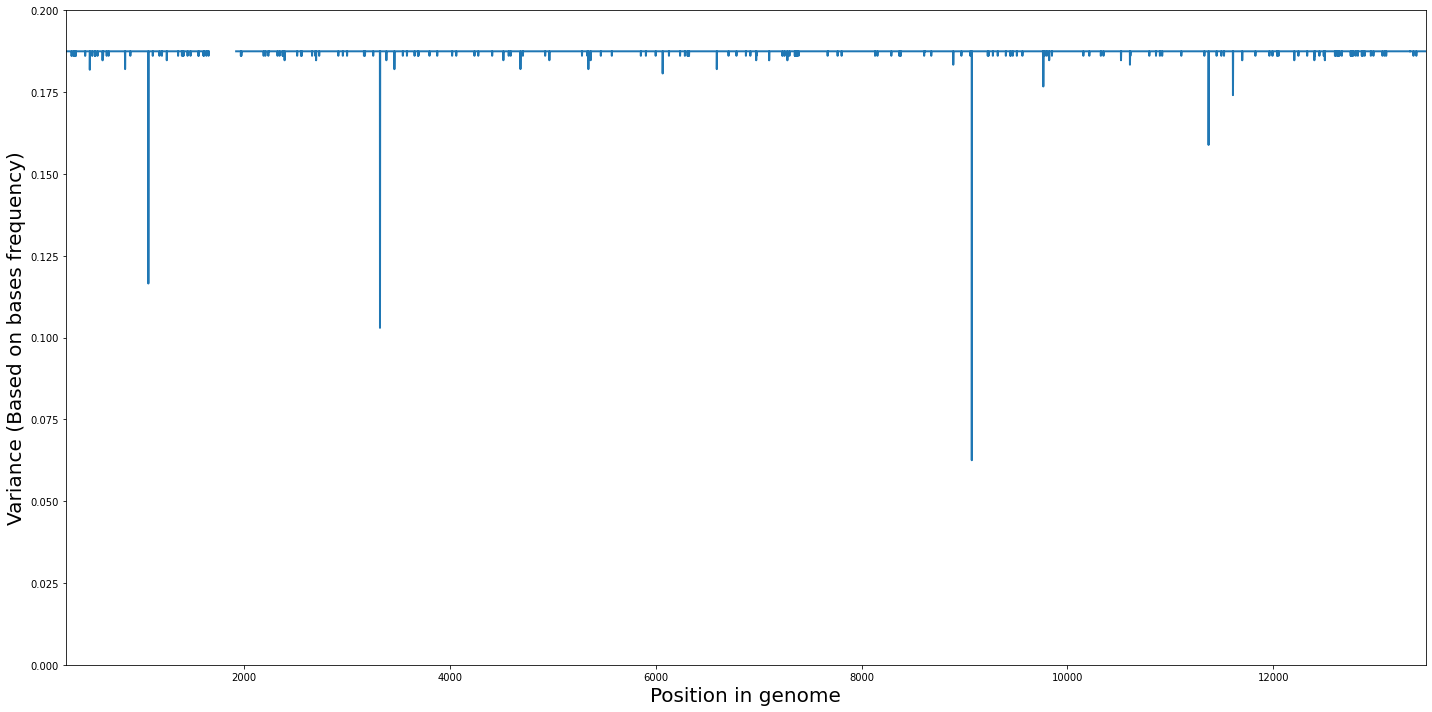

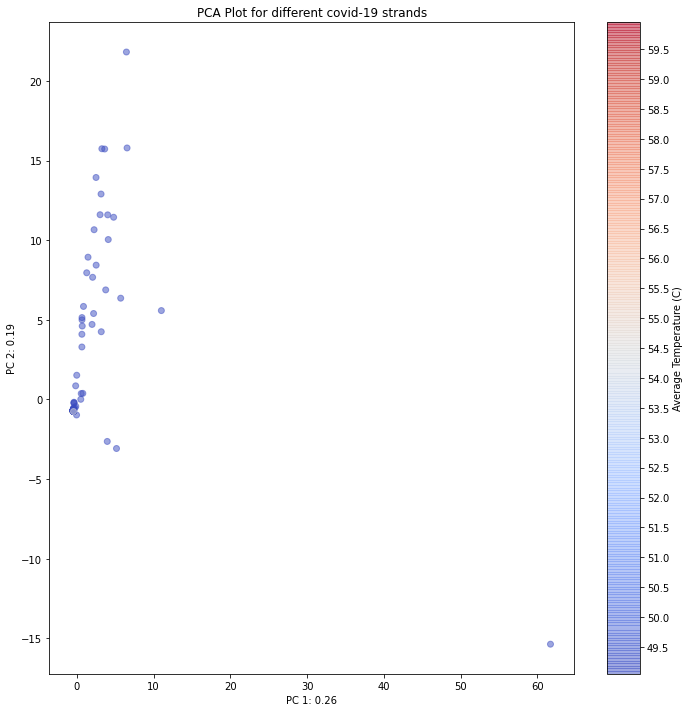

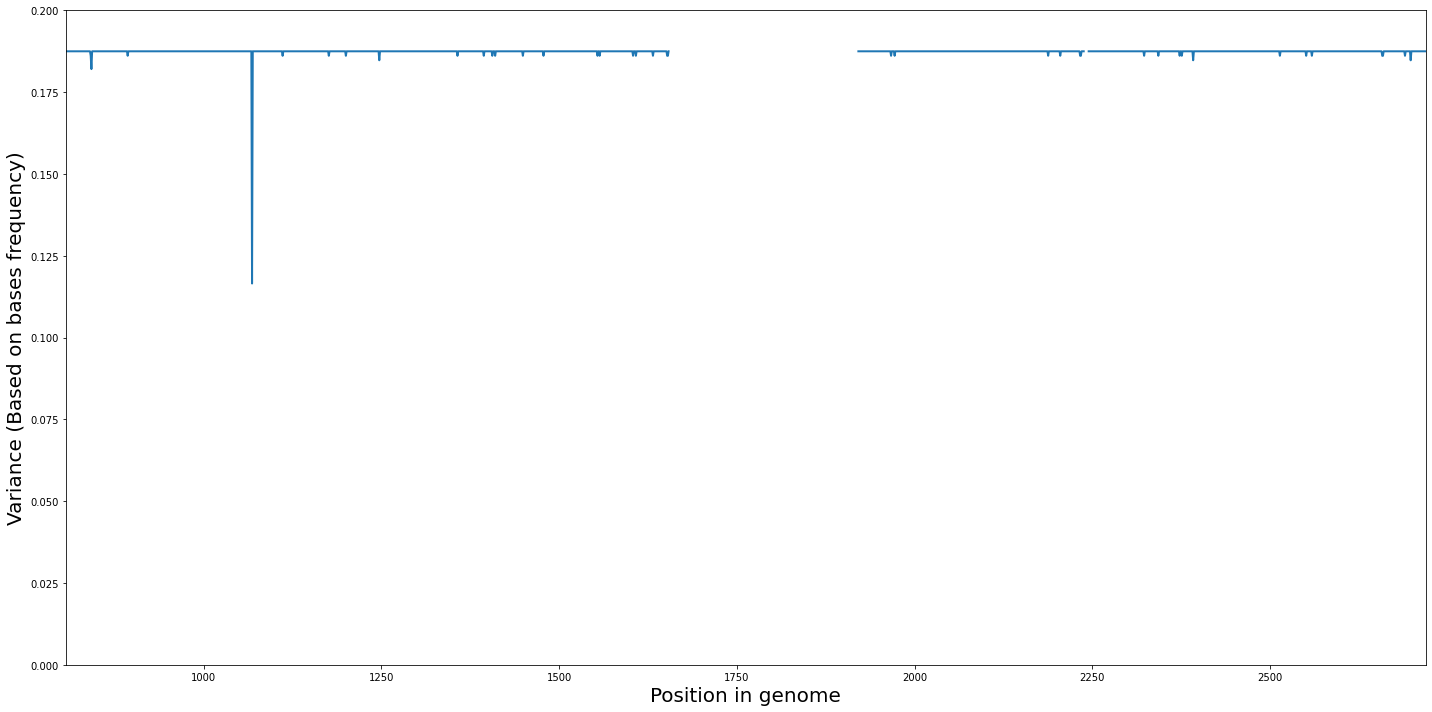

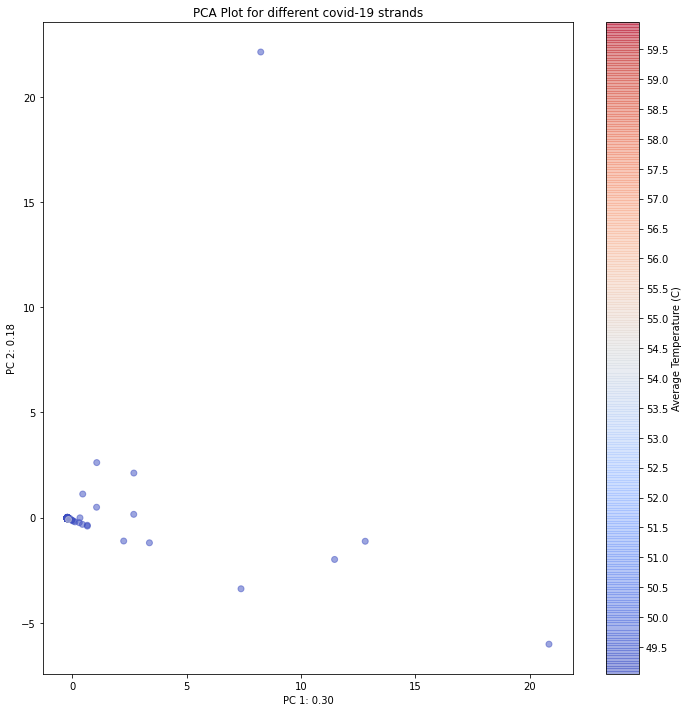

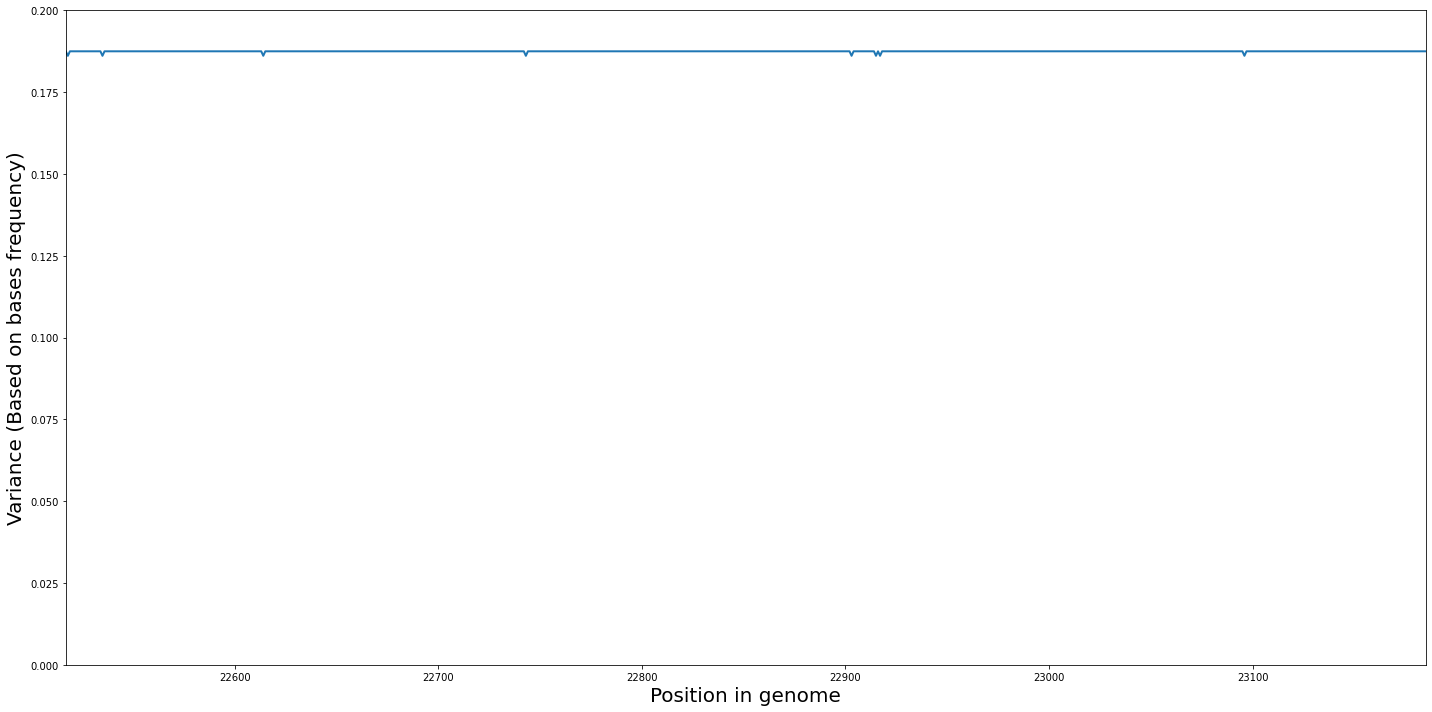

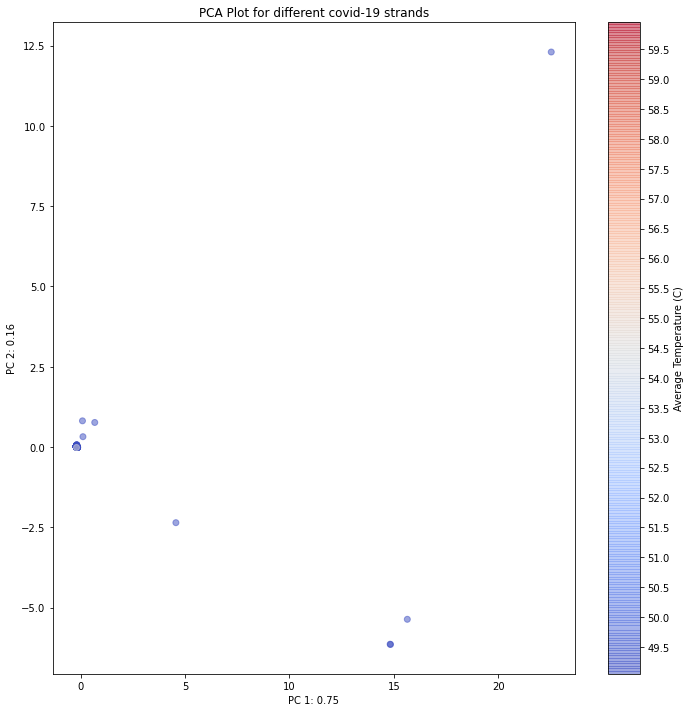

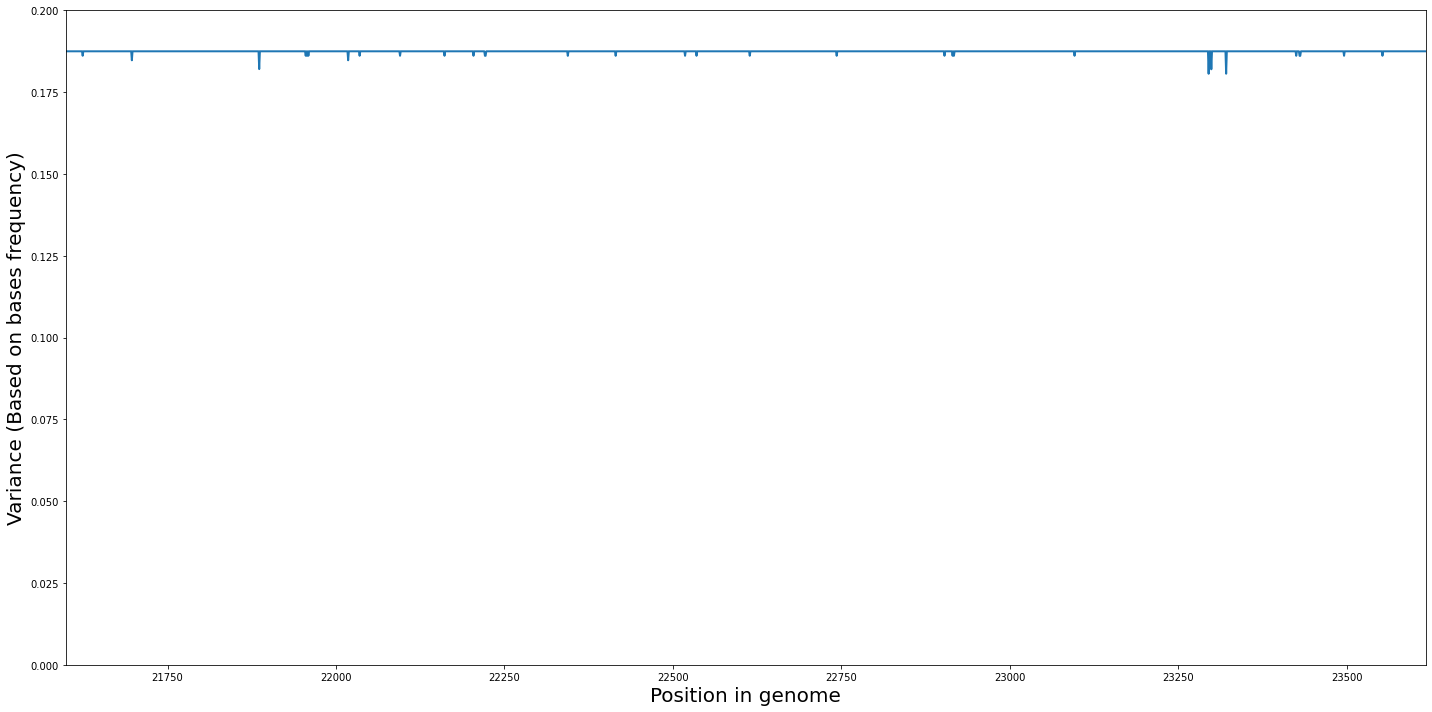

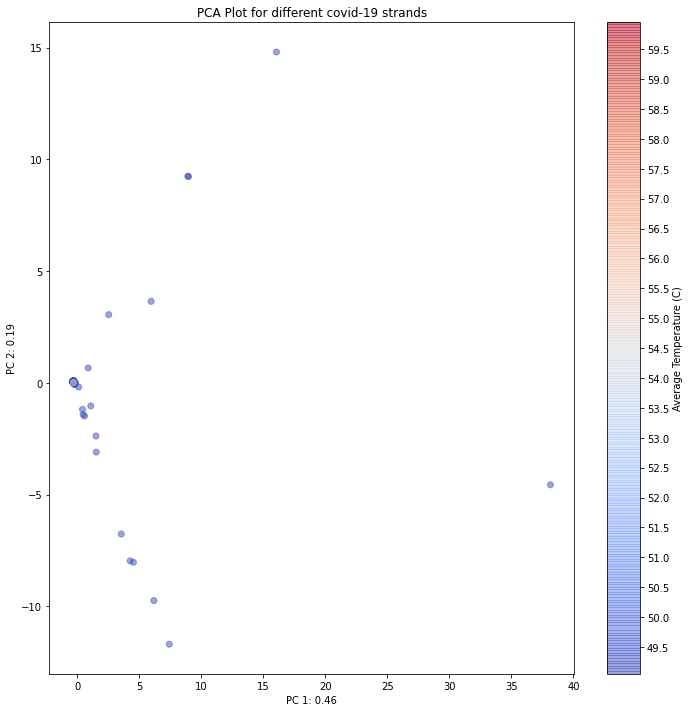

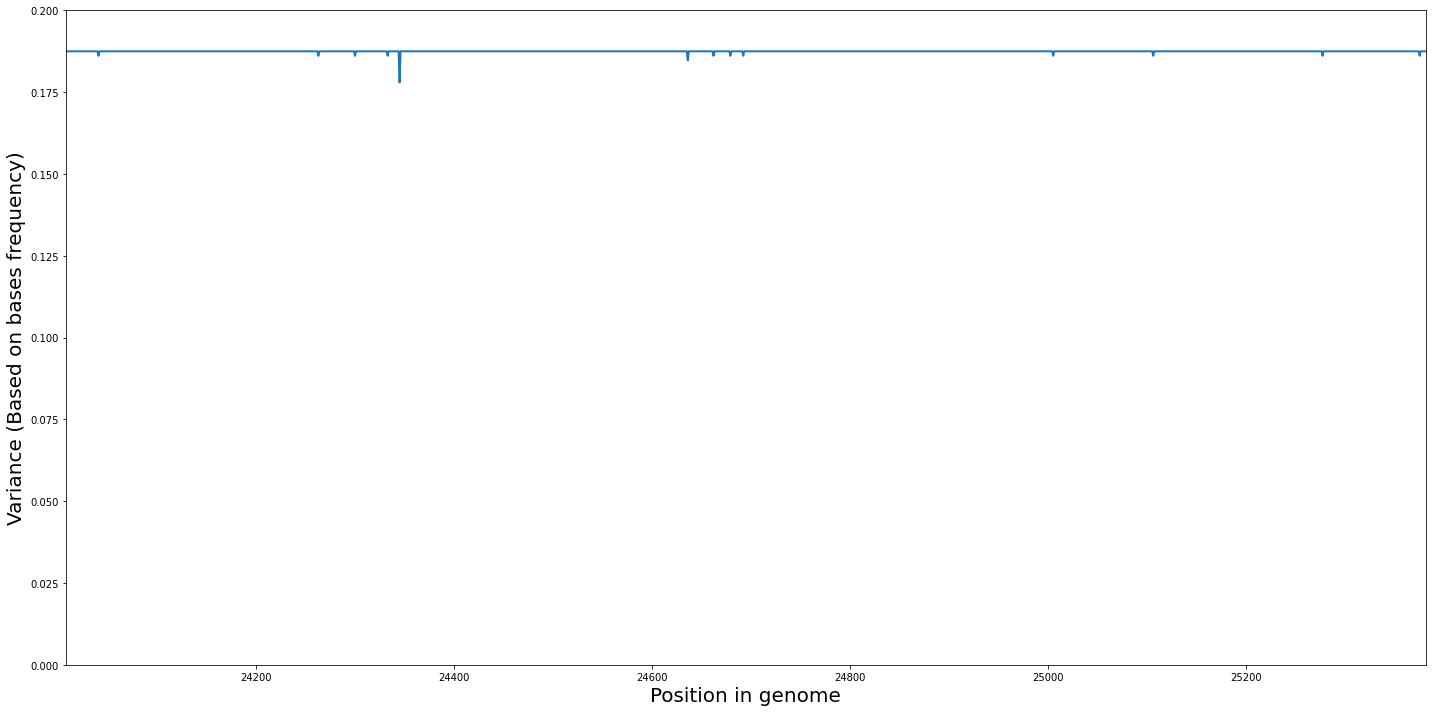

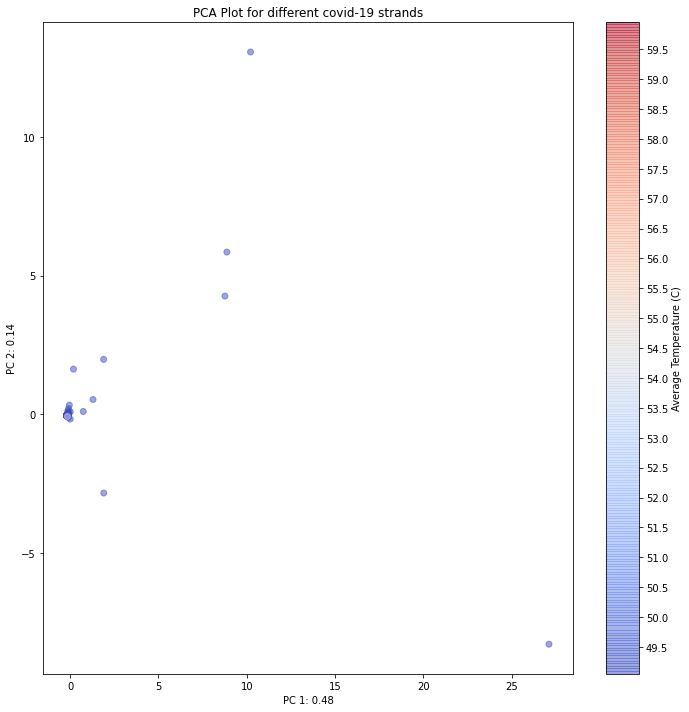

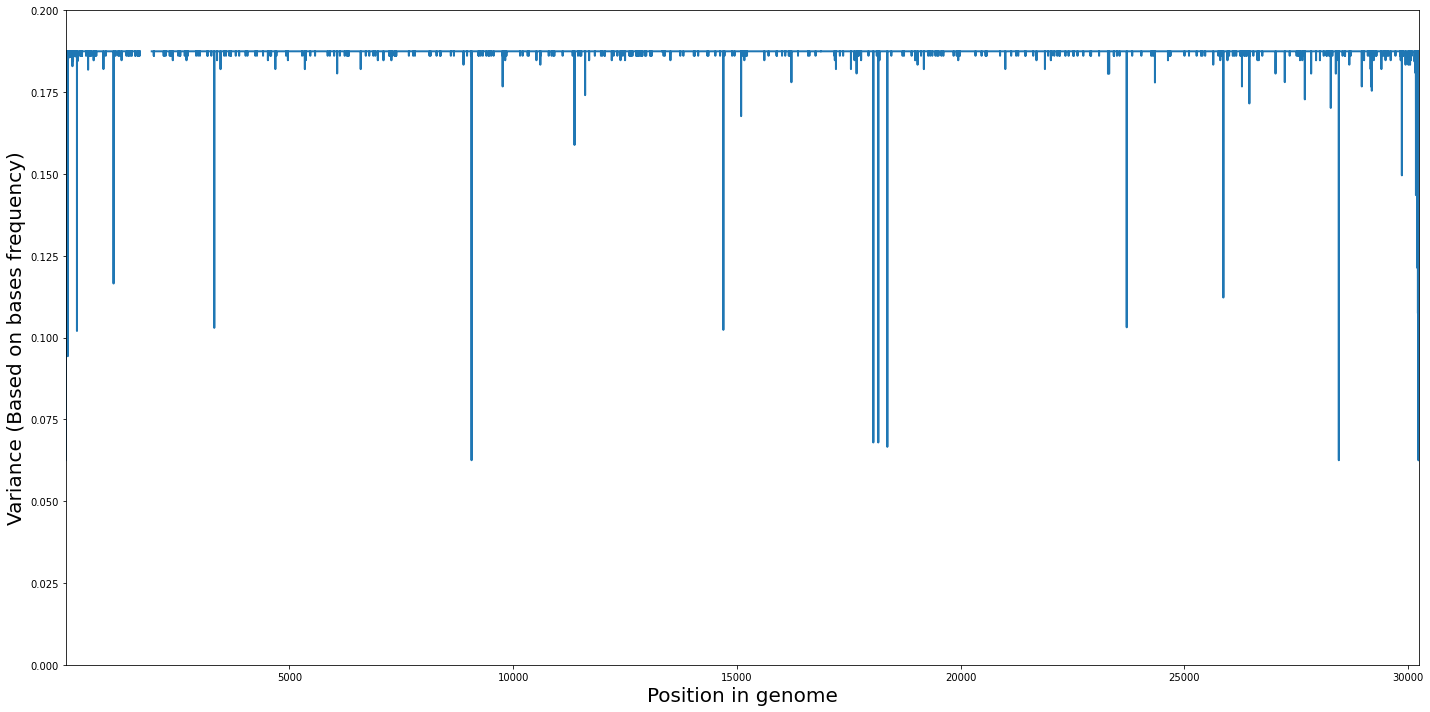

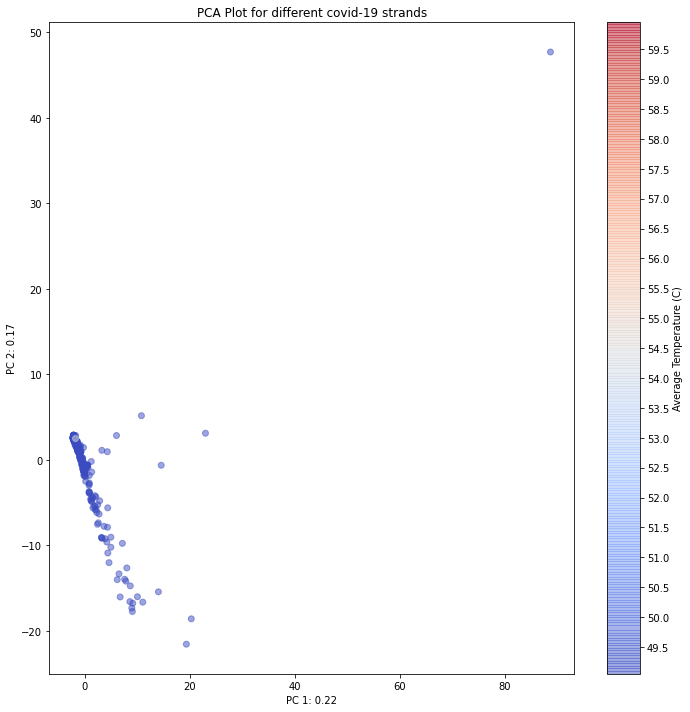

''

In [25]:
for i in range(len(roi)):
    start = roi.loc[i, 'start']
    end = roi.loc[i, 'end']
    
    visualize_var(var_aligned, start, end)
    pca_pipeline(start, end, 1)
    
    
visualize_var(var_aligned, 1, len(aligned_ref))
pca_pipeline(1, len(aligned_ref), 1)

''

## Detecting correlation between temperature and genetics

Idea:

    1. Find some genetic / genomic pattern
    2. Group samples by the patterns
    3. Compare the temperature of the groups with the temperature
    4. Statistically assess if temp can be explained by genetics


In [26]:
# Use temperature dict to make the temperature array based on each sample
def get_temperature_from_geo(geo_loc, temperature_dict=temperature_dict):
    if geo_loc == 'South Korea':
        geo_loc = 'S. Korea'
    
    if geo_loc == 'NA':
        pass
    
    if geo_loc in temperature_dict.keys():    
        return temperature_dict[geo_loc]
    
    else:
        pass

# Add temperature to columns in meta_info
meta_info.loc[:, 'Temperature'] = np.vectorize(get_temperature_from_geo)(meta_info.loc[:, "Geo_Location"])

[['-']
 ['C']
 ['T']]
[['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['T']
 ['T']
 ['T']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['C']
 ['C']
 ['T']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['C']
 ['C']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['T']
 ['C']
 ['C']
 ['T']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['C']
 ['T']
 ['C']
 ['C']
 ['C']
 ['T']
 ['T']
 ['T']
 ['T']
 ['C']
 ['C']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['C']
 ['T']
 ['C']
 ['C']
 ['C']
 ['C']
 ['T']
 ['C']
 ['T']
 ['-']
 ['T']
 ['T']
 ['T']
 ['C']
 ['-']
 ['C'

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


<Figure size 720x720 with 0 Axes>

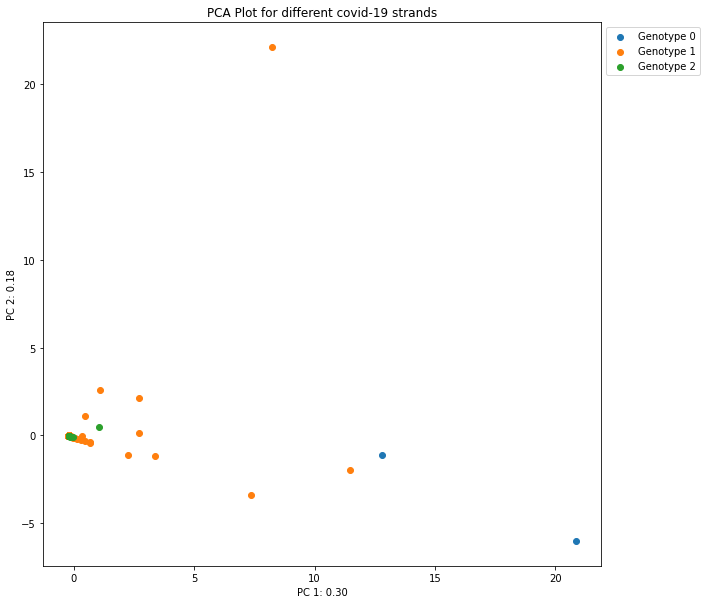

In [45]:
# We check where is the source of variation for the specific NSP region
selected_i = 
var_ths = 0.150
start = roi.loc[selected_i, 'start']
end = roi.loc[selected_i, 'end']
var_aligned_region = var_aligned[start : end]
aligned_seq_array_region = aligned_seq_array[:, start : end]
var_aligned_region_higher_variance = aligned_seq_array_region[:, var_aligned_region < var_ths]

# Categorize each point to groups, then show where they lie in the PCA
genotypes = np.unique(var_aligned_region_higher_variance, axis = 0)
print(genotypes)
print(var_aligned_region_higher_variance)

# Get PCA of this region
dosage = get_dosage_matrix_interesting_regions(start, end, 1)
pcs, pca_explained_var = conduct_pca_on_dosage_matrix(dosage)

# Plot the PCA
plt.figure(figsize=(10, 10))
# Get expained variances
PC1_explained_ratio, PC2_explained_ratio = pca_explained_var[0], pca_explained_var[1]

# Make base plot
fig = plt.figure(figsize=(10,10))
plt.title('PCA Plot for different covid-19 strands')
plt.xlabel(f'PC 1: {str(PC1_explained_ratio)[:4]}')
plt.ylabel(f'PC 2: {str(PC2_explained_ratio)[:4]}')

PC_1, PC_2 = pcs[:, 0], pcs[:, 1]

group_filters = []
for i in range(len(genotypes)):
    geno = genotypes[i]
    group_filter = []
    for var_seq in var_aligned_region_higher_variance:
        group_filter.append((var_seq == geno).all())
    group_filter = np.array(group_filter)
    
    group_filters.append(group_filter)

    plt.scatter(PC_1[group_filter], PC_2[group_filter], c=f'C{i}', label=f'Genotype {i}')

plt.legend(bbox_to_anchor=(1,1), loc="upper left")

plt.show()

In [36]:
# Conduct anova / t-test

# Set up dataframe
accession_groups = []
accession_group_temperature = []
genotype_groups = []
for i in range(len(group_filters)):
    group_filter = group_filters[i]
    accession_groups.append(meta_info.loc[group_filter, 'Accession'].values)
    accession_group_temperature.append(meta_info.loc[group_filter, 'Temperature'].values)
    genotype_groups.append(np.repeat(i, len(meta_info.loc[group_filter, 'Accession'].values)))

accession_groups = [element for sublist in accession_groups for element in sublist] 
accession_group_temperature_flattened = [element for sublist in accession_group_temperature for element in sublist] 
genotype_groups = [element for sublist in genotype_groups for element in sublist] 
    
temp_group_df = pd.DataFrame({'Temperature':  accession_group_temperature_flattened, 'Genotype': genotype_groups, 'Accession': accession_groups})
temp_group_df = temp_group_df.dropna()
# Conduct anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Temperature ~ Genotype', data=temp_group_df).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
anova_p_value = anova_table.loc['Genotype', 'PR(>F)']

# Test anova assumptions
# Normality, shapiro wilk
import scipy.stats as stats
w, shapiro_p_value = stats.shapiro(model.resid)

print(f'How many genotype groups: {len(accession_group_temperature)}')
# Homogeneity of Variance, Bartlett's test
def quickly_drop_na(input_array):
    return input_array[~np.isnan(input_array)]
w, bartlett_p_value = stats.bartlett(quickly_drop_na(accession_group_temperature[0]),
                                     quickly_drop_na(accession_group_temperature[1]),
                                     quickly_drop_na(accession_group_temperature[2])
                                    )
# Print P-values
print(f'ANOVA p-value: {anova_p_value}')
print(f'Shapiro p-value: {shapiro_p_value}')
print(f'Barlett p-value: {bartlett_p_value}')

How many genotype groups: 3
ANOVA p-value: 0.6209944355296515
Shapiro p-value: 4.449534701725485e-32
Barlett p-value: 0.0


/usr/local/lib/python3.7/site-packages/scipy/stats/morestats.py:2241: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)


In [38]:
# Conduct kruskal wallis, non-parametric version of anova
w, kruskal_p_value = stats.kruskal(quickly_drop_na(accession_group_temperature[0]),
                                   quickly_drop_na(accession_group_temperature[1]),
                                   quickly_drop_na(accession_group_temperature[2])
                                  )
print(f'Kruskal Wallis p-value: {kruskal_p_value}')

# Conduct Dunn-test
import scikit_posthocs as sp
dunn_pairwise = sp.posthoc_dunn(temp_group_df, val_col='Temperature', group_col='Genotype')
dunn_pairwise

Kruskal Wallis p-value: 0.46045797967943214


0         1         2
0 -1.000000  0.925191  0.387341
1  0.925191 -1.000000  0.214812
2  0.387341  0.214812 -1.000000

Text(0.5, 0, 'Genotype Group')

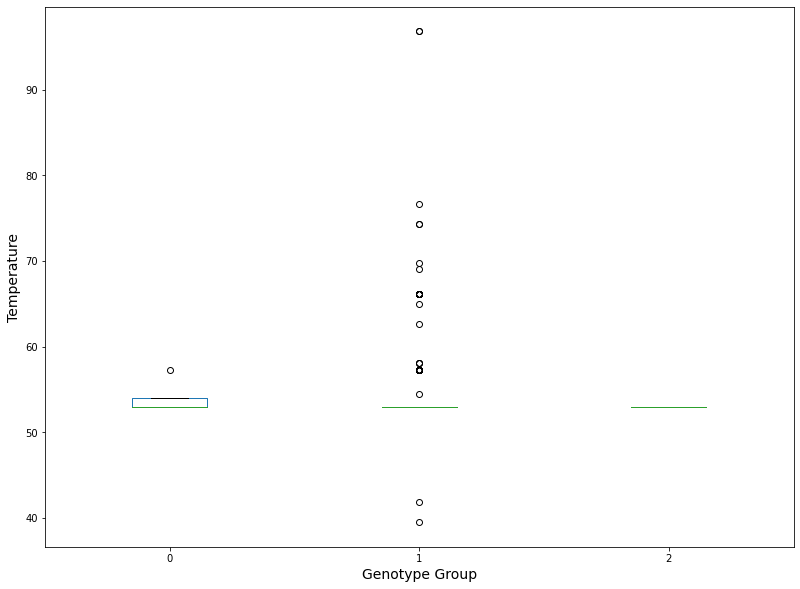

In [39]:
# Plot boxplot comparing the groups

temp_group_df.loc[:, ['Temperature', 'Genotype']].boxplot(column='Temperature',
                                                          by='Genotype',
                                                          figsize=(13, 10),
                                                          grid= False,
                                                         )
plt.suptitle('')
plt.title(f'')
plt.ylabel('Temperature', fontsize=14)
plt.xlabel('Genotype Group', fontsize=14)